*Course: Multiple Linear Regression in Public Health  
Presenter: Dr. John McGready  
Institution: Johns Hopkins University*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

Regression provides a general framework for the estimation and testing procedures. Multiple regression allows for the extension of the methods from linear regression to allow for multiple predictors of an outcome with a single method, and allow for the estimation of adjusted associations.  

The basic structure of these multiple  regression models is a linear equation:  

$y = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + ... + \beta_{p}x_{p}$  

where $x_{1} ... x_{p}$ model the predictors of interest.  

- For continuous outcomes, the left-hand side is the mean of the outcome 𝑦, $\hat y$, and the regression type is linear regression.  
- For binary outcomes, the left-hand side is the ln(odds) of the binary outcome, $ln \frac{p}{1-p}$, where p is the probability that $y = 1$ (proportion of y values equal to 1) and the regression type is logistic regression.  
- For time-to-event outcomes where the individual event and censoring times are not known, 𝑦𝑦is yes/no indicator of whether the event occurred in the common follow-up period; the left-hand side is ln(incidence rate), and the regression type is Poisson regression.  
- For time-to-event outcomes where the individual event and censoring times are known, 𝑦𝑦is a composite outcome taking into account both the time and whether the event occurred;the left-hand side is ln(hazard rate), and the regression type is Cox regression.  
- Each slope estimates the difference in the left-hand side for a one-unit difference in the corresponding $x$, adjusted (!) for the other variables in the model.

data: https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Examination&CycleBeginYear=2013 and https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Demographics&CycleBeginYear=2013

In [2]:
import xport

In [3]:
lines = []
with open('data/NHANES_Examination_Data_2013_2014.XPT', 'rb') as f:
    for row in xport.Reader(f):
        lines.append(row)
columns = ['seqn', 'weight', 'height', 'bmi']
df_nhanes_exam = pd.DataFrame(np.array(lines)[:, [0,2,8,10]], columns=columns)

lines = []
with open('data/NHANES_Demographic_Data_2013_2014.XPT', 'rb') as f:
    for row in xport.Reader(f):
        lines.append(row)      
columns = ['seqn', 'gender', 'age', 'race']
df_nhanes_demo = pd.DataFrame(np.array(lines)[:, [0,3,4,7]], columns=columns)

lines = []
with open('data/NHANES_Blood_Pressure_Data_2013_2014.XPT', 'rb') as f:
    for row in xport.Reader(f):
        lines.append(row)       
columns = ['seqn', 'bp_sys', 'bp_dia']
df_nhanes_bp = pd.DataFrame(np.array(lines)[:, [0,11,12]], columns=columns)

df_nhanes = df_nhanes_demo.set_index('seqn').join(df_nhanes_exam.set_index('seqn'), on='seqn', how='inner')
df_nhanes['gender'].replace({1:'male',
                             2:'female'}, inplace=True)
df_nhanes['race'].replace({1:'mexican_american',
                           2:'other_hispanic',
                           3:'white',
                           4:'black',
                           6:'asian',
                           7:'other'}, inplace=True)
df_nhanes['obese'] = df_nhanes['bmi'].apply(lambda x: 1 if x >= 30 else 0)

df_nhanes = df_nhanes.join(df_nhanes_bp.set_index('seqn'), on='seqn', how='inner')
df_nhanes.head()

,gender,age,race,weight,height,bmi,obese,bp_sys,bp_dia
seqn,,,,,,,,,
73557.0,male,69.0,black,78.3,171.3,26.7,0,122.0,72.0
73558.0,male,54.0,white,89.5,176.8,28.6,0,156.0,62.0
73559.0,male,72.0,white,88.9,175.3,28.9,0,140.0,90.0
73560.0,male,9.0,white,32.2,137.3,17.1,0,108.0,38.0
73561.0,female,73.0,white,52.0,162.4,19.7,0,136.0,86.0


In [4]:
# save variables into separate series for plotting
gender = df_nhanes['gender']
race = df_nhanes['race']

### 1. Multiple Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [6]:
# dictionaries for encoding
dict_gender = {'male':0, 'female':1}
dict_race = {'mexican_american':0,
             'other_hispanic':1,
             'white':2,
             'black':3,
             'asian':4,
             'other':5}

In [7]:
df_nhanes.dropna(axis=0, inplace=True)
df_nhanes['gender'].replace(dict_gender, inplace=True)
df_nhanes['race'].replace(dict_race, inplace=True)
df_nhanes = pd.get_dummies(df_nhanes, columns=['race'], drop_first=True)

In [8]:
def lin_reg(df, x, y):
    """
    Performs linear regression using one or more features
    Inputs:
        df: dataframe
        x:  list of columns, if column name ends with "*" indicates presence
            of dummy columns for that feature
        y:  outcome with coefficients, r-squared value and a list of column names
    """
    df_copy = df.copy()
    
    cols = []
    for col in x:
        if col.endswith('*'):
            for c in df_copy.columns:
                if c.startswith(col[:-1]):
                    cols.append(c)
        else:
            cols.append(col)
    
    lr = LinearRegression()
    lr.fit(df_copy[cols], df_copy[y])
    
    y_pred = lr.predict(df_copy[cols])
    r2 = r2_score(df_copy[y], y_pred)
    
    return {'intercept': lr.intercept_,
            'coefficients':lr.coef_,
            'r-squared':r2}, cols

In [9]:
def print_regr_result(res, d=None):
    """
    Prints the results of a regression analysis
    Inputs:
        res: the results returned from the regression analysis
        d: a dictionary containing mappings used to encode categorical variables
    """
    print('Intercept:', round(res[0]['intercept'],2))
    
    if d:
        rev_dict = {v:k for k,v in d.items()}
        print("Reference group:", rev_dict[0])
    
        for i, col in enumerate(res[1]):
            print(rev_dict[i+1], res[0]['coefficients'][i])

        print('R-squared:', round(res[0]['r-squared'],2))
    else:
        print("Slope:", res[0]['coefficients'])
        print("R-squared:", res[0]['r-squared'])
        

In [10]:
col_lst = ['gender']
target = 'bp_sys'
res = lin_reg(df_nhanes, col_lst, target)
print_regr_result(res, dict_gender)

Intercept: 119.81
Reference group: male
female -3.434146944833852
R-squared: 0.01


From the output above we can see that the unadjusted association of systolic blood pressure with sex is: $119.8 -3.4x_{1}$ where $x_{1} = 1$ for females and 0 for males. The R^{2} value is 0.01. As can be seen from the graph below, the difference in mean systolic blood pressure between males and females is indeed very small.

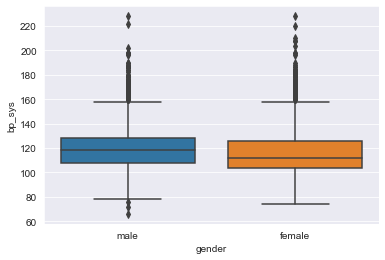

In [11]:
sns.boxplot(x=gender, y=df_nhanes['bp_sys']);

Next, let's try race:

In [12]:
col_lst = ['race*']
target = 'bp_sys'
res = lin_reg(df_nhanes, col_lst, target)
print_regr_result(res, dict_race)

Intercept: 115.64
Reference group: mexican_american
other_hispanic 1.2381052359572189
white 3.337763154132308
black 4.392816388258724
asian 1.0122055383370945
other -1.2178063223639561
R-squared: 0.01


The unadjusted association with ethnicity is: $115.6 + 1.2x_{1} +3.3x_{2} +4.4x_{3} + 1.0x_{4} -1.2x_{5}$ where $x_{1} = 1$ for other_hispanic, $x_{2} = 1$ for white, etc. with an $R^{2}$ of 0.01. 

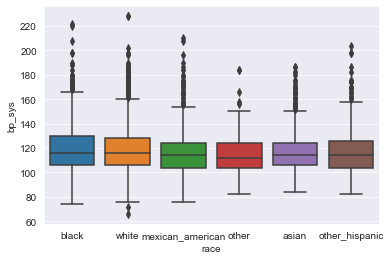

In [13]:
sns.boxplot(x=race, y=df_nhanes['bp_sys']);

Next, let's investigate the possible association between age (a continuous variable) and systolic blood pressure.

In [14]:
col_lst = ['age']
target = 'bp_sys'
res = lin_reg(df_nhanes, col_lst, target)
print_regr_result(res)

Intercept: 99.57
Slope: [0.47965378]
R-squared: 0.34160448746617156


The unadjusted association of systolic blood pressure with age is: $99.6 + 0.48x_{1}$ where $x_{1}$ is age in years with an R-squared value 0f 0.34.

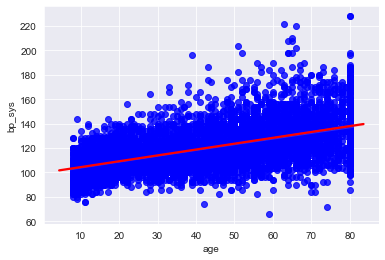

In [15]:
g = sns.regplot(x='age', y='bp_sys', data=df_nhanes,
                scatter_kws={"color": "blue"},
                line_kws={"color": "red"});

#### Multiple Linear Regression: An Example

In [16]:
col_lst = ['age', 'gender', 'race*']
target = 'bp_sys'
res = lin_reg(df_nhanes, col_lst, target)
print("Column names:", res[1])
print("Intercept:", res[0]['intercept'])
print("Coefficients:", res[0]['coefficients'])
print("R-squared:", res[0]['r-squared'])

Column names: ['age', 'gender', 'race_1', 'race_2', 'race_3', 'race_4', 'race_5']
Intercept: 101.29399972363476
Coefficients: [ 0.49128866 -3.59784551 -0.61921427 -1.86485106  2.59138622 -1.6943693
  1.35228131]
R-squared: 0.3613152808737773


- The overall regression equation is: $\hat{y} = \hat\beta_{0} + \hat\beta_{1}x_{1} + \hat\beta_{2}x_{2} + \hat\beta_{3}x_{3} + \hat\beta_{4}x_{4} + \hat\beta_{5}x_{5} + \hat\beta_{6}x_{6}$ where $x_{1}$ is age in years, $x_{2} =1$ for female, zero otherwise, $x_{3} = 1$ for `other_hispanic`, zero otherwise, $x_{4} = 1$ for `white`, zero otherwise, etc.

- A multiple regression using `age`, `gender`, and `race` as predictors, shows that the unadjusted associaton of systolic blood pressure is 0.48 while the age-adjusted association is 0.49.

- The adjusted association with respect to gender is $-3.6x_{2}$ (second coefficient in the list) which is slightly different from the unadjusted value of -3.4. Note that $x_{2} = 1$ for women. 

- The adjusted association with respect to race is $-1.9x_{4}$ for persons identifying as white while the unadjusted value was 3.34.

- The overall $R^{2}$ value is 0.36 which is slightly higher than that for age alone (0.34).

- Generically speaking, each slope ̂$\beta_{i}$, i to p,is the estimated adjusted mean difference in $\hat y$ for two groups who differ by one unit in $x_{i}$, adjusted for all other 𝑥s in the model.

- The intercept, ̂$\beta_{0}$, is the estimated mean for the group with all xs = 0. This may not be a relevant quantity, depending on the predictor set $x_{1}, x_{2}, ... x_{p}$, but it is still necessary to specify the regression equation fully.

#### Basics of Model Estimation, and Handling Uncertainty in the Resulting Estimates

## TBD

In [17]:
import statsmodels.api as sm

#### Estimate Group Means and Mean Differences for Groups Who Differ in More than One Predictor with Multiple Linear Regression  

##### Estimate a single group mean, based on a specific set of predictor values, using multiple linear regression  

The MLR equation: $\hat{y} = 101.3 + 0.49x_{1} + -3.6x_{2} - 0.62x_{3} - 1.86x_{4} + 2.59x_{5} - 1.69x_{6} + 1.35x_{7}$.

Estimate the mean SBP for 50-year-old females who identify as non-Hispanic White:

In [18]:
def estimate_bp(coeffs, l1, l2=None):
    """
    Estimate group means or mean differences for groups
    who differ in more than one predictor with MLR
    Inputs:
        coeffs: array of regression coefficients
        l1, l2: array(s) of values to compare
    """
    if np.any(l2):
        return np.sum(np.subtract(coeffs*l1, coeffs*l2))
    else:
        return np.sum(coeffs*l1)
    
coeffs = np.array([101.3, 0.49, 3.6, 0.62, -1.86, 2.59, -1.69, 1.35])
l1 = np.array([1, 50, 0, 0, 1, 0, 0, 0])

print(estimate_bp(coeffs, l1)) # 50-year-old female, white

123.94


##### Estimate a mean difference in the outcome 𝑦 for two groups who differ in more than one predictor  

Estimate the mean difference SBP for 50-year-old females who identify as non-Hispanic White and 60-year-old males who identify as Hispanic:

In [19]:
coeffs = np.array([101.3, 0.49, 3.6, 0.62, -1.86, 2.59, -1.69, 1.35])
l1 = np.array([1, 50, 0, 0, 1, 0, 0, 0]) # 50-year-old female, white
l2 = np.array([1, 60, 0, 1, 0, 0, 0, 0]) # 60-year-old male, hispanic

print(round(estimate_bp(coeffs, l1, l2),2))

-7.38


#### The “Linearity” Assumption and Estimating Amount of Variability Explained by Multiple Predictors  

Multiple linear regression analysis makes several key assumptions:

- There must be a linear relationship between the outcome variable and the independent variables.  Scatterplots can show whether there is a linear or curvilinear relationship.
- Multiple regression assumes that the residuals are normally distributed.
- Multiple regression assumes that the independent variables are not highly correlated with each other.  This assumption is tested using Variance Inflation Factor (VIF) values.
- Homoscedasticity: This assumption states that the variance of error terms are similar across the values of the independent variables. A plot of standardized residuals versus predicted values can show whether points are equally distributed across all values of the independent variables.

In [20]:
X = sm.add_constant(np.array(df_nhanes[['age', 'gender']])) # add intercept values!
y = np.array(df_nhanes['bp_sys'])
model = sm.OLS(y, X)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     1928.
Date:                Sat, 06 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:27:45   Log-Likelihood:                -29065.
No. Observations:                7104   AIC:                         5.814e+04
Df Residuals:                    7101   BIC:                         5.816e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.3997      0.388    261.481      0.0

Checking modeling assumptions with respect to a single regressor, x1 (age).

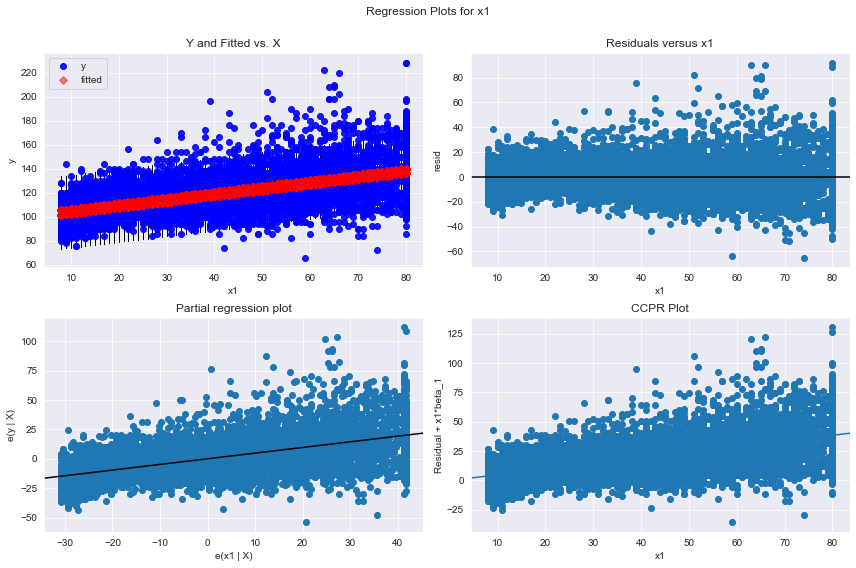

In [21]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model_fit, "x1", fig=fig)

#### Investigating Effect Modification with Multiple Linear Regression  

There is an important distinction between confounding and effect modification. Confounding is a distortion of an estimated association caused by an unequal distribution of another risk factor. When there is confounding, we would like to account for it (or adjust for it) in order to estimate the association without distortion. In contrast, effect modification is a biological phenomenon in which the magnitude of association differs at different levels of another factor, e.g., a drug that has an effect on men, but not in women. 

Effect modification results are easiest to interpret when at least one of the two pieces is binary or categorical  
- Treatment (drug vs. placebo) and biological sex (male, female)
- Height (continuous) and biological sex (male, female)
- Age (continuous) and ethnicity (Mexican American, Hispanic, Non-Hispanic White, Non-Hispanic Black, Other)  

It can be assessed when both pieces are continuous, but is “messy” to interpret
- Height (continuous) and weight (continuous)  

Option 1  
- Stratify the data into difference subsets, based on each level of one of the variables involved (sex, ethnicity, etc.) and estimated separate regressions on each subset
- Compare the estimated slopes for each predictor across the different subsets  
- This is a good option if the researcher is concerned that one measure (the stratifying variable) modifies all outcome predictor relationships

Option 2
- Create an interaction term between the main exposure of interest in terms of effect modification—and its potential effect modifier
- Run a regression that includes the exposure of interest, the potential effect modifier, the interaction term, and all other predictors of interest
- This allows for an assessment of a specific effect modification of interest while using all of the data to estimate other (adjusted) outcome exposure relationships
- This also allows for a formal statistical test of effect modification

The National Hospital Ambulatory Medical Care Surveys (NHAMCS) provide data from samples of patient records selected from emergency departments (EDs) and outpatient departments (OPDs) of a national sample of hospitals. The resulting national estimates describe the use of hospital ambulatory medical care services in the United States. For the 2008 survey, data were colected from 209 OPDs and 431 EDs. Among the variables included are age, race, and sex of the patient, reason for the visit physician's diagnoses, cause of injury, surgical procedures (OPD's only), medication therapy, and expected source of payment (https://www.icpsr.umich.edu/web/ICPSR/studies/29922/summary).

In [22]:
import statsmodels.formula.api as smf

In [23]:
def load_NHAMCS():
    df = pd.read_csv("data/NHAMCS_ED_2008.tsv", sep="\t")
    df = df[df['RACEUN'] != -9] # -9 indicates missing
    df = df[df['WAITTIME'] != -9]
    df = df[df['BPSYS'] != -9]
    df['RACEUN'].replace({1:0, 2:1, 3:2, 4:2, 5:2, 6:2}, inplace=True) # Group all except white and black into other
    df['SEX'].replace({2:0,}, inplace=True) # 0:male, 1:female   
    
    dummies = pd.get_dummies(df['RACEUN'], prefix='race', drop_first=True)
    df = df.join(dummies)
    df.drop('RACEUN', axis=1, inplace=True)
    columns = ['AGE', 'SEX', 'race_1', 'race_2', 'PAYPRIV', 'BPSYS', 'WAITTIME']
    return df[columns]

df = load_NHAMCS()

Boxplot of waiting time.

Minimum wait time: 0
Maximum wait time: 1407
Mean (and stdev) of wait time: 57.19 ( 75.67 )


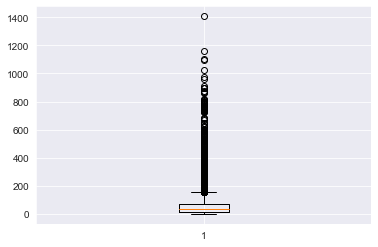

In [24]:
plt.boxplot(df['WAITTIME']);
print("Minimum wait time:", df['WAITTIME'].min())
print("Maximum wait time:", df['WAITTIME'].max())
print("Mean (and stdev) of wait time:", round(df['WAITTIME'].mean(),2),"(",
      round(df['WAITTIME'].std(),2), ")")

Multiple linear regression with multiple predictors and `WAITTIME` as the outcome.

In [25]:
results = smf.ols('WAITTIME~SEX+race_1+race_2+PAYPRIV+BPSYS', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               WAITTIME   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     56.06
Date:                Sat, 06 Jun 2020   Prob (F-statistic):           4.25e-58
Time:                        15:27:54   Log-Likelihood:            -1.1980e+05
No. Observations:               20876   AIC:                         2.396e+05
Df Residuals:                   20870   BIC:                         2.397e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     56.8937      3.061     18.585      0.0

The regression equation with the actual intercept and slope estimates is:  

$ \hat{y} = 56.9 + 4.9x_{1} + 17.0x_{2} +6.3x{3} -5.9x_{4} -0.03x_{5}$  

where $x_{1} = 1$ when female, 0 for males, $x_{2} = 1$ for black, 0 for white or other, $x_{3} = 1$ for other racial identity, 0 for white or black, $x_{4} = 1$ for private insurance, 0 othrwise and $x_{5}$ is systolic blood pressure (mmHg).

##### Stratify the data into difference subsets, based on each level of one of the variables involved (sex, ethnicity, etc.) and estimated separate regressions on each subset and compare the estimated slopes for each predictor across the different subsets

In [26]:
# Unadjusted association between systolic blood pressure and waittime
res_unadj = smf.ols('WAITTIME~BPSYS', data=df).fit()
print(res_unadj.params)

Intercept    63.086752
BPSYS        -0.044377
dtype: float64


In [27]:
# Sex-adjusted association between systolic blood pressure and waittime
res_adj = smf.ols('WAITTIME~BPSYS+SEX', data=df).fit()
print(res_adj.params)

Intercept    59.664586
BPSYS        -0.039521
SEX           5.064007
dtype: float64


In [28]:
# Association between systolic blood pressure and waittime: males
males = df[df['SEX'] == 0]
res_sex_males = smf.ols('WAITTIME~BPSYS', data=males).fit()
print("Coefficients for males:\n", res_sex_males.params)

Coefficients for males:
 Intercept    56.132405
BPSYS        -0.013159
dtype: float64


In [29]:
# Association between systolic blood pressure and waittime: females
females = df[df['SEX'] == 1]
res_sex_females = smf.ols('WAITTIME~BPSYS', data=females).fit()
print("\nCoefficients for females:\n", res_sex_females.params)


Coefficients for females:
 Intercept    67.483426
BPSYS        -0.060428
dtype: float64


##### Create an interaction term between the main exposure of interest in terms of effect modification—and its potential effect modifier.

In [30]:
df['SEX_BPSYS_INT'] = df['SEX'] * df['BPSYS']

In [31]:
res_int = smf.ols('WAITTIME~BPSYS+SEX+SEX_BPSYS_INT', data=df).fit()
print(res_int.params)

Intercept        56.132405
BPSYS            -0.013159
SEX              11.351021
SEX_BPSYS_INT    -0.047269
dtype: float64


### 2. Multiple Logistic Regression: Examples

In [32]:
# Add HDL data to NHANES dataframe
lines = []
with open('data/NHANES_Lab_HDL_Data_2013_2014.XPT', 'rb') as f:
    for row in xport.Reader(f):
        lines.append(row)       
columns = ['seqn', 'hdl']
df_nhanes_hdl = pd.DataFrame(np.array(lines)[:, [0,1]], columns=columns)
df_nhanes = df_nhanes.join(df_nhanes_hdl.set_index('seqn'), on='seqn', how='inner')
df_nhanes.head()

,gender,age,weight,height,bmi,obese,bp_sys,bp_dia,race_1,race_2,race_3,race_4,race_5,hdl
seqn,,,,,,,,,,,,,,
73557.0,0,69.0,78.3,171.3,26.7,0,122.0,72.0,0,0,1,0,0,65.0
73558.0,0,54.0,89.5,176.8,28.6,0,156.0,62.0,0,1,0,0,0,50.0
73559.0,0,72.0,88.9,175.3,28.9,0,140.0,90.0,0,1,0,0,0,60.0
73560.0,0,9.0,32.2,137.3,17.1,0,108.0,38.0,0,1,0,0,0,61.0
73561.0,1,73.0,52.0,162.4,19.7,0,136.0,86.0,0,1,0,0,0,85.0


Look at the unadjusted association between obesity and sex:

In [33]:
res_lr = smf.logit('obese~gender', data=df_nhanes).fit()
print(res_lr.summary())

Optimization terminated successfully.
         Current function value: 0.603570
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  obese   No. Observations:                 7104
Model:                          Logit   Df Residuals:                     7102
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Jun 2020   Pseudo R-squ.:                0.005810
Time:                        15:27:55   Log-Likelihood:                -4287.8
converged:                       True   LL-Null:                       -4312.8
Covariance Type:            nonrobust   LLR p-value:                 1.451e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0637      0.039    -27.422      0.000      -1.140      -0.988
gender         0.3697      0.

Thus, the unadjusted ln(odds of obsesity) = $-1.06 + 0.37x_{1}$ where $x_{1} = 1$ for females, zero for males. Therefore the $\hat{OR}$ of obesity in females compared to males is $e^{0.37}$ or approximately 1.45 (95% CI: 1.31, 1.60).

Look at the unadjusted association between obesity and hdl:

In [34]:
res_lr2 = smf.logit('obese~hdl', data=df_nhanes).fit()
print(res_lr2.summary())

Optimization terminated successfully.
         Current function value: 0.583266
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  obese   No. Observations:                 6639
Model:                          Logit   Df Residuals:                     6637
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Jun 2020   Pseudo R-squ.:                 0.04781
Time:                        15:27:55   Log-Likelihood:                -3872.3
converged:                       True   LL-Null:                       -4066.7
Covariance Type:            nonrobust   LLR p-value:                 1.467e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1793      0.111     10.662      0.000       0.962       1.396
hdl           -0.0394      0.

The unadjusted ln(odds of obesity) = $1.18 - 0.04x_{1}$ where $x_{1} = HDL (mg/dL)$. The slope $\beta_{1}$ estimates the ln odds ratio of obesity for two groups whose HDL levels differ by one mg/dL. Thus, the $\hat{OR} = e^{-0.0394}$ or approximately 0.961 (95% CI: 0.957, 0.966). In other words, higher HDL subjects (by one mg/dL) have a 4% lower odds of being obese when compared to lower HDL subjects.

It is possible that `gender` and `hdl` are related. Indeed, the boxplot below shows that females have higher HDL levels.

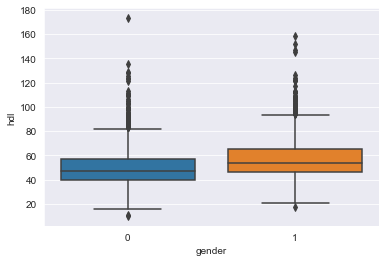

In [35]:
sns.boxplot(x='gender', y='hdl', data=df_nhanes);

In [36]:
res_lr3 = smf.logit('obese~gender+hdl', data=df_nhanes).fit()
print(res_lr3.summary())

Optimization terminated successfully.
         Current function value: 0.572128
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  obese   No. Observations:                 6639
Model:                          Logit   Df Residuals:                     6636
Method:                           MLE   Df Model:                            2
Date:                Sat, 06 Jun 2020   Pseudo R-squ.:                 0.06599
Time:                        15:27:56   Log-Likelihood:                -3798.4
converged:                       True   LL-Null:                       -4066.7
Covariance Type:            nonrobust   LLR p-value:                2.794e-117
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1747      0.113     10.425      0.000       0.954       1.395
gender         0.6994      0.

- From the results presented above we can see that the unadjusted association of gender with obesity is 1.45 (1.31, 1.60) while the unadjusted association of hdl with obesity is 0.961 (0.957, 0.966).  
- When both features are included in the logistic regression, the *hdl*-adjusted odds ratio of obesity for females is 2.01 (1.79, 2.26) and the *gender*-adjusted association between obesity and hdl is given by an odds ratio of 0.954 (0.950, 0.958).  
- Note that the 95% confidence interval of the gender-adjusted odds ratio does not overlap with that of the unadjusted odds ratio and is therefore statistically different.

##### Estimating Group Odds and Proportions, and Odds Ratios for Groups Who Differ in More than One Predictor with Multiple Linear Regression

In [37]:
# Select individuals 18 years of age or older
df_logreg = df_nhanes[df_nhanes["age"] >= 18].copy()

In [38]:
# Add age quartiles to dataframe
df_logreg["age_quartiles"] = pd.qcut(df_logreg["age"], q=4)

In [39]:
res_lr4 = smf.logit('obese~gender+hdl+age_quartiles', data=df_logreg).fit()
print(res_lr4.summary())

Optimization terminated successfully.
         Current function value: 0.602068
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  obese   No. Observations:                 5127
Model:                          Logit   Df Residuals:                     5121
Method:                           MLE   Df Model:                            5
Date:                Sat, 06 Jun 2020   Pseudo R-squ.:                 0.07752
Time:                        15:27:56   Log-Likelihood:                -3086.8
converged:                       True   LL-Null:                       -3346.2
Covariance Type:            nonrobust   LLR p-value:                7.060e-110
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept             

The model, as shown above is ln(odds of obesity) = $0.792 + 0.796x_{1} -0.045x_{2} + 0.61x_{3} + 0.82x_{4} + 0.56x_{5}$.  

**Estimate the proportion of obese adult females with HDL of 75 mg/dL who are 65 years old (4th age quartile).**

In [40]:
def est_prop(coeffs, value_lst):
    """
    Calculate the odds and probability given a set of coefficients and values
    """
    res = np.sum(coeffs * value_lst)
    odds = np.exp(res)
    prob = odds/(1+odds)
    return (odds, prob)

odds, prob = est_prop(np.array([0.792, 0.796, -0.045, 0.61, 0.82, 0.56]), np.array([1, 1, 75, 0, 0, 1]))
print("The odds of obesity are:", round(odds, 2))
print("The probability of obesity is:", round(prob, 2))

The odds of obesity are: 0.29
The probability of obesity is: 0.23


**Display a graph showing the estimated proportion (probability) of being obese for females and males by HDL level (mg/dL) and age quartile.**

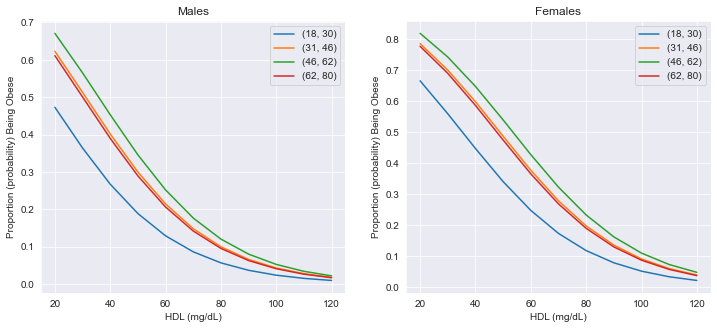

In [41]:
def plot_hdl_obese():
    """
    Returns a plot of estimated proportion for a specific group using a range
    of HDL levels
    """
    d = {0:"Males", 1:"Females"}
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    coeff_quartiles = [0, 0.61, 0.82, 0.56]
    age_range = [(18,30), (31,46), (46,62), (62,80)]
    
    for gender in [0, 1]: # males, females
        for i in range(len(coeff_quartiles)):
            y = []
            for x in range(20, 121, 10):
                odds = np.exp(0.792)*np.exp(0.796*gender)*np.exp(-0.045*x)*np.exp(coeff_quartiles[i])
                prob = odds/(1+odds)
                y.append(prob)
            ax[gender].plot(range(20,121,10),y, label=age_range[i]);
        ax[gender].set_xlabel("HDL (mg/dL)")
        ax[gender].set_ylabel("Proportion (probability) Being Obese")
        ax[gender].set_title(d[gender])
        ax[gender].legend()

plot_hdl_obese()

- The estimated probability of obesity is lowest in the youngest age quartile.
- Males have a lower probability of being obese, as compared to females, at comparable HDL levels.
- The probability of obesity decreases with increasing HDL levels for both males and females.

**Estimate odds ratio of obesity for females with HDL of 75 mg/dL who are 65 years old, compared to males with HDL of 80 mg/dL who are 50 years old.**

In [42]:
coeffs = np.array([0.792, 0.796, -0.045, 0.61, 0.82, 0.56])
females = np.array([1, 1, 75, 0, 0, 1]) #intercept, gender, age, hdl, age_q2, age_q3, age_q4
males = np.array([1, 0, 80, 0, 1, 0]) #intercept, gender, age, hdl, age_q2, age_q3, age_q4

odds_ratio = np.exp(np.sum(coeffs * (females - males)))
print("Estimated odds ratio:", round(odds_ratio, 2))

Estimated odds ratio: 2.14


### 3. Multiple Cox Regression

Multiple Cox regression is a tool that relates the hazard of a binary outcome occurring over time to multiple predictors $x_{1}, x_{2} ... x_{p}$ via a linear equation of the form: ln(hazard of outcome) = $ln(\lambda(t, x_{1} - x_{p}))$ = $ln(\hat \lambda_{0}(t)) + \hat \beta_{1}x_{1} + \hat \beta_{2}x_{2} + ... + \hat \beta_{p}x_{p}$.  
Generically speaking, each slope ̂$\hat\beta_{i}$, i = 1 to p is the estimated adjusted ln hazard ratio of the outcome for two groups who differ by one unit in $x_{i}$, adjusted for all other xs in the model.

data https://www4.stat.ncsu.edu/~boos/var.select/pbc.html  

futime = (number of days between registration and the earlier of death, transplantion, or study analysis time in July, 1986)  
status = (0=alive, 1=liver transplant, 2=dead)  
drug = (1= D-penicillamine, 2=placebo)

In [57]:
# Load and prepare data
columns = ['id', 'futime', 'status', 'drug', 'age', 'sex', 'ascites', 'hepato', 'spiders',
            'edema', 'bili', 'chol', 'albumin', 'copper', 'alk_phos', 'sgot', 'trig', 'platelet',
            'protime', 'stage']
df_pbc = pd.read_csv('data/pbc.txt', sep=r"\s*", names=columns, engine='python')
df_pbc['drug'].replace({'2':'0'}, inplace=True) # set placebo as reference (0)
df_pbc = df_pbc[df_pbc['drug'] != '.'] # remove rows with missing data in 'drug' column
df_pbc['drug'] = df_pbc['drug'].astype(int)
df_pbc['status'].replace({1:0, 2:1}, inplace=True) # recode liver transplant as alive(0), dead as 1
df_pbc.head()

C:\Users\Michael\Anaconda3\lib\site-packages\pandas\io\parsers.py:2455: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Users\Michael\Anaconda3\lib\site-packages\pandas\io\parsers.py:2458: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


,id,futime,status,drug,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk_phos,sgot,trig,platelet,protime,stage
0,1,400,1,1,21464,1,1,1,1,1.0,14.5,261,2.60,156,1718.0,137.95,172,190,12.2,4
1,2,4500,0,1,20617,1,0,1,1,0.0,1.1,302,4.14,54,7394.8,113.52,88,221,10.6,3
2,3,1012,1,1,25594,0,0,0,0,0.5,1.4,176,3.48,210,516.0,96.10,55,151,12.0,4
3,4,1925,1,1,19994,1,0,1,1,0.5,1.8,244,2.54,64,6121.8,60.63,92,183,10.3,4
4,5,1504,0,0,13918,1,0,1,1,0.0,3.4,279,3.53,143,671.0,113.15,72,136,10.9,3


In [51]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv

# construct structured array with "Surv"
# https://scikit-survival.readthedocs.io/en/latest/generated/sksurv.util.Surv.html?highlight=surv
data_y = Surv.from_dataframe('status', 'futime', df_pbc)
cox = CoxPHSurvivalAnalysis()
cox.fit(df_pbc[['drug']], data_y)
print('Slope for treatment (ln(hazard ratio)):', round(float(cox.coef_),3))
print('Hazard ratio for treatment:', round(float(np.exp(cox.coef_)),2))

Slope for treatment (ln(hazard ratio)): 0.057
Hazard ratio for treatment: 1.06


In [52]:
# Convert age from days to years
df_pbc["age_years"] = np.around(df_pbc["age"]/365)
# Add column with age quartiles
df_pbc["age_q"] = pd.qcut(df_pbc["age_years"], q=4)

Reminder: Proportional hazard regression models (“Cox models”) are a regression technique for censored data. They allow variation in the time to an event to be explained in terms of covariates, similar to what is done in a linear or generalized linear regression model. These models express the covariate effects in terms of “hazard ratios”, meaning the the hazard (instantaneous event rate) is multiplied by a given factor depending on the value of the covariates.

In [53]:
status = df_pbc["status"].values
mod = smf.phreg('futime ~ drug+age_q+sex', data=df_pbc, status=status, ties="efron")
rslt = mod.fit()
print(rslt.summary())

                                          Results: PHReg
Model:                                  PH Reg                   Sample size:                   312
Dependent variable:                     futime                   Num. events:                   125
Ties:                                   Efron                                                      
---------------------------------------------------------------------------------------------------
                                               log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
---------------------------------------------------------------------------------------------------
age_q[T.Interval(42.0, 50.0, closed='right')]  0.1146    0.3026 1.1215  0.3789 0.7048 0.6198 2.0293
age_q[T.Interval(50.0, 57.0, closed='right')]  0.6091    0.2847 1.8387  2.1391 0.0324 1.0523 3.2128
age_q[T.Interval(57.0, 78.0, closed='right')]  1.0911    0.2832 2.9776  3.8523 0.0001 1.7091 5.1875
drug                                       

The resulting equation for the ln(hazard of death) = $ln(\hat\lambda_{0}(t)) - 0.057x_{1} + 0.115x_{2} + 0.609x_{3} + 1.09x_{4} - 0.0388x_{5}$ where $x_{1} = 1$ for the drug, zero for placebo, $x_{2}, x_{3}, x_{4} = 1$ for the respective age quartiles, zero otherwise, and $x_{5} = 1$ for female, zero for male.

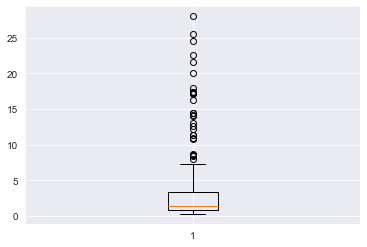

In [54]:
# Let's see what the distribution of the feature "bili" looks like
plt.boxplot(df_pbc["bili"]);

In [55]:
# Add quartiles for bilirubin (mg/dL)
df_pbc["bili_q"] = pd.qcut(df_pbc["bili"], q=4)

In [56]:
status = df_pbc["status"].values
mod1 = smf.phreg('futime ~ drug+age_q+bili_q+sex', data=df_pbc, status=status, ties="efron")
rslt1 = mod1.fit()
print(rslt1.summary())

                                            Results: PHReg
Model:                                  PH Reg                     Sample size:                     312
Dependent variable:                     futime                     Num. events:                     125
Ties:                                   Efron                                                          
-------------------------------------------------------------------------------------------------------
                                                 log HR log HR SE    HR      t    P>|t|  [0.025  0.975]
-------------------------------------------------------------------------------------------------------
age_q[T.Interval(42.0, 50.0, closed='right')]    0.3906    0.3030  1.4779  1.2893 0.1973 0.8161  2.6762
age_q[T.Interval(50.0, 57.0, closed='right')]    1.0147    0.2898  2.7585  3.5017 0.0005 1.5632  4.8678
age_q[T.Interval(57.0, 78.0, closed='right')]    1.2624    0.2890  3.5338  4.3682 0.0000 2.0056  6.2263
bili_

Note the attenuated hazard ratios for `drug` and `sex` as well as the different `age`-quartiles.